In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import os
import pandas as pd
from scipy.stats import linregress
from lmfit import Model
import seaborn as sns

[8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514 8.47418514
 8.47418514 8.47418514]
[[Model]]
    Model(model_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 50
    # variables        = 3
    chi-square         = 359.883231
    reduced chi-square = 7.65709003
    Akaike info crit   = 104.687831
    Bayesian info crit = 110.423900
    R-squared          = -15.1710513
[[Variables]]
    a:  2.22026645 +/- 0.17852316 (8.04%) (init = 1)
    b:  0.29475035 +/- 0.

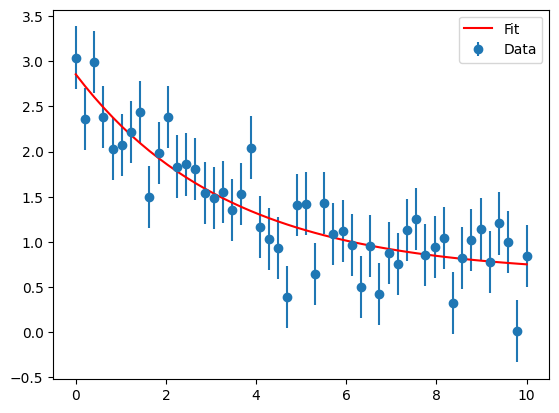

In [2]:


# Define the function to fit
def model_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Generate example data with random Gaussian errors
x_data = np.linspace(0, 10, 50)
y_data = model_func(x_data, 2, 0.5, 1)
y_noise = np.random.normal(loc=0, scale=0.3, size=y_data.shape)
y_data += y_noise

# Define the measurement errors as the standard deviation of the noise
sigma = np.std(y_noise)

# Calculate the inverse variance weights based on the measurement errors
weights = 1 / sigma ** 2 * np.ones_like(y_data)
print(weights)
# Define the lmfit model
model = lmfit.Model(model_func)

# Define the initial guesses for the parameters
params = model.make_params(a=1, b=1, c=1)

# Fit the model to the data with weights
result = model.fit(y_data, params, x=x_data, weights=weights)

# Print the result summary
print(result.fit_report())

# Plot the results
plt.errorbar(x_data, y_data, yerr=sigma, fmt='o', label='Data')
plt.plot(x_data, result.best_fit, 'r-', label='Fit')
plt.legend()
plt.show()


,values,Type,fit
0,1.055746e-06,conductivity,nw
1,9.413705e-07,conductivity,w
2,3.318431e+05,cr,nw
3,2.575628e+05,cr,w


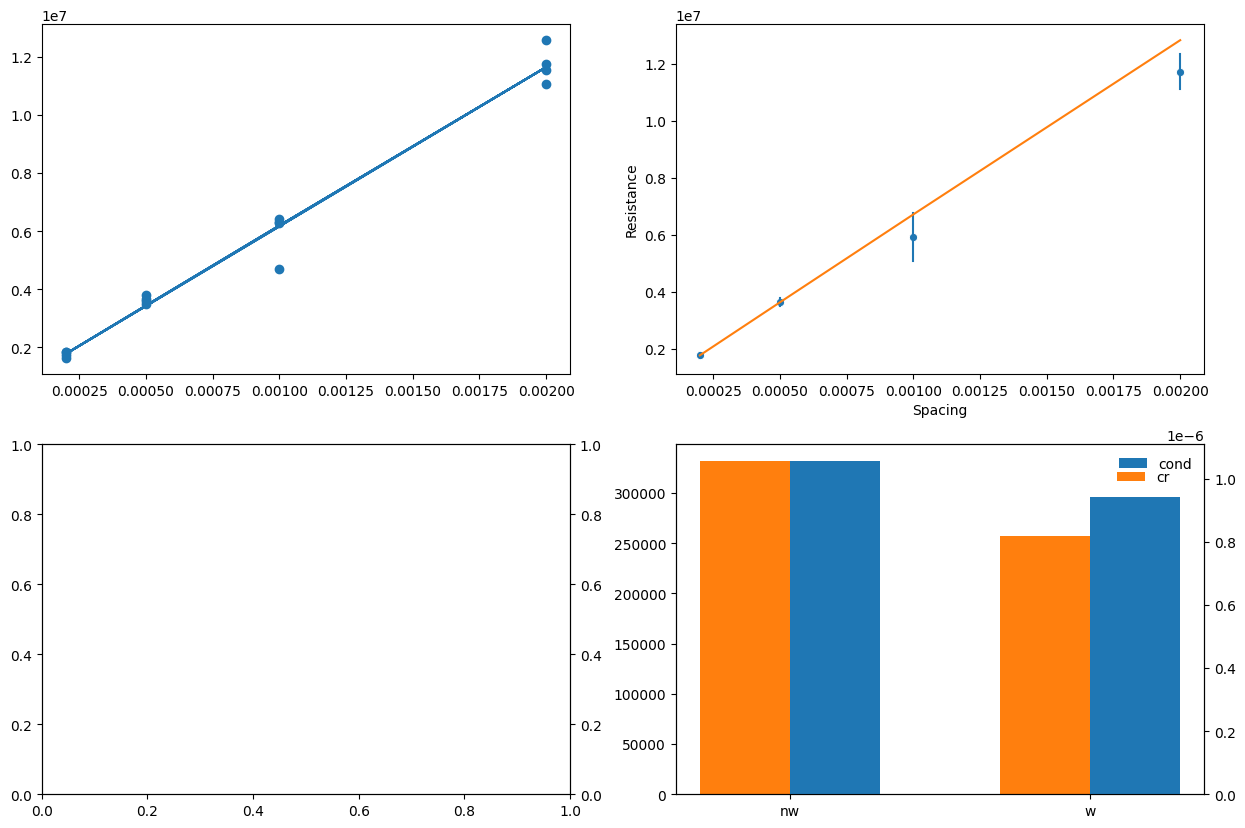

In [84]:
def line(x, m, b):
    return x * m + b

def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

col = ['Potential (V)', 'Current (A)', 'Time (s)']
thickness = 90
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_23'
sample = path[-5:]
files = [os.path.join(path, i) for i in os.listdir(path)]
iv_fit = pd.DataFrame()
resistance = pd.DataFrame(columns = ['Spacing', 'Resistance'])

n = 0
for i in files:
    df = pd.read_csv(i, sep = ';', skiprows=1, names = col)
    slope, intercept, rvalue, pvalue, stderr = linregress(df[col[0]], df[col[1]])
    df['Fit (A)'] = line(df[col[0]], slope, intercept)

    if i[-5:-4] == '1':
        df['Spacing'] = 2e-4
        resistance.loc[n] = (2e-4, 1/slope)
    elif i[-5:-4] == '2':
        df['Spacing'] = 5e-4
        resistance.loc[n] = (5e-4, 1/slope)
    elif i[-5:-4] == '3':
        df['Spacing'] = 10e-4
        resistance.loc[n] = (10e-4, 1/slope)
    elif i[-5:-4] == '4':
        df['Spacing'] = 20e-4
        resistance.loc[n] = (20e-4, 1/slope)
    
    iv_fit = pd.concat([iv_fit, df])
    n += 1


spac = [2e-4, 5e-4, 10e-4, 20e-4]
average_df = pd.DataFrame()
weights = pd.DataFrame()
for i in spac:
    df = resistance[resistance.Spacing == i].mean()
    df2 = resistance[resistance.Spacing == i].copy()
    std = np.std(df2['Resistance'])
    df['Weight'] = 1 / std ** 2
    # df2['Weight'] = 1 / std ** 2
    average_df = pd.concat([average_df, df], axis=1)
    weights = pd.concat([weights, df2])
average_df = average_df.T.reset_index(drop = True)

result_nw = gmodel5.fit(resistance['Resistance'], param5, s = resistance['Spacing'])
cr = gmodel5.eval(result_nw.params, s = 0) / 2
rs =  result_nw.values['r_s']
conductivity_nw = 1 / (rs * thickness * 1e-7)

result_w = gmodel5.fit(average_df['Resistance'], param5, s = average_df['Spacing'], weights = average_df['Weight'])
cr_w = gmodel5.eval(result_w.params, s = 0) / 2
rs_w =  result_w.values['r_s']
conductivity_w = 1 / (rs_w * thickness * 1e-7)



df_results = pd.DataFrame( {'values': [conductivity_nw, conductivity_w, cr, cr_w],
                            'Type' : ['conductivity', 'conductivity', 'cr', 'cr'],
                            'fit' : ['nw', 'w', 'nw', 'w']}
                          )

display(df_results)

# print(result_nw.fit_report())
# print('================================================================================================================================================')
# print(result_w.fit_report())




# PLOT      =================================================================================================================================================
fig, ax = plt.subplots(2,2, dpi = 100, figsize = (15,10))
ax2 = ax[1,0].twinx()
ax3 = ax[1,1].twinx()
ax[0,0].scatter(resistance['Spacing'], resistance['Resistance'])
ax[0,0].plot(resistance['Spacing'], result_nw.best_fit)

# ax[1].scatter(average_df['Spacing'], average_df['Resistance'])
sns.lineplot(data = resistance, x = 'Spacing', y = 'Resistance', errorbar = 'sd', err_style='bars', ax = ax[0,1], linestyle = '', marker = 'o')
ax[0,1].plot(average_df['Spacing'], result_w.best_fit)

# sns.barplot(x = ['Conductivity S/cm','Contact Resistance ($\Omega$)'], y = [conductivity_nw,0], ax = ax[1,0])
# sns.barplot(x = ['Conductivity S/cm','Contact Resistance ($\Omega$)'], y = [0,cr], ax = ax2)

# sns.barplot(x = ['Conductivity S/cm','Contact Resistance ($\Omega$)'], y = [conductivity_w,0], ax = ax[1,1])


# df_results = df_results.melt(id_vars='index')
# sns.barplot(x = ['Non-weighted Fit', 'Weighted Fit'], y = [conductivity_nw, conductivity_w], ax = ax[1,1])
# sns.barplot( data = df_results[df_results.Type == 'cr'], x = 'fit', y = 'values', ax = ax[1,1], width = 0.1)
# sns.barplot( data = df_results[df_results.Type == 'conductivity'], x = 'fit', y = 'values', ax = ax3, width = 1, dodge = False)

ax3.bar(['nw', 'w'], [conductivity_nw, conductivity_w], align = 'edge', width = 0.3, label = 'cond')
ax[1,1].bar(['nw', 'w'], [cr, cr_w], align = 'edge', width = -0.3, color = 'tab:orange', label = 'cr')

ax3.legend(frameon = False)
ax[1,1].legend(frameon = False, loc = (0.825,0.87))

# print(df_results.index)
# sns.barplot(x = ['Conductivity S/cm','Contact Resistance ($\Omega$)'], y = [0,cr_w], ax = ax3)
# sns.barplot(x = ['Non-weighted Fit', 'Weighted Fit'], y = [cr,cr_w], ax = ax3), dodge
# sns.barplot(data = df_results, hue = index, ax = ax3)
# print(result_nw.best_fit)
# print(result_w.best_fit)

# display(weights)
# average_df